![PyTorch logo](https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png)

# From dummy to state-of-the-art
by José Fernández Portal


## Agenda
- Introduction
- Python from two perspectives:
 1. Numpy with superpowers
 2. A Deep Learning framework
- Custom model example

## Target audience
This tutorial assumes audience is familiarized with Neural Nets.

## Introduction

### What is Pytorch?
- Open-source Deep Learning framework
- Developed by Facebook AI Team
- Alternative to TensorFlow/Keras

## Numpy with superpowers

At first sight PyTorch is a numeric computation library similar to Numpy.

So, let's start by importing PyTorch.

In [2]:
import torch

### Basic operations

Indeed, it will feel very familiar to Numpy's users...

PyTorch's tensors are almost equivalent to Numpy's arrays.

In [2]:
a = torch.tensor([[5., 3], [4, 1], [3, 6]])   # np.array(...)
a, a.shape

(tensor([[5., 3.],
         [4., 1.],
         [3., 6.]]), torch.Size([3, 2]))

In [3]:
b = torch.rand(2, 4)

In [4]:
c = a @ b 
c

tensor([[3.9015, 2.5264, 2.0615, 3.2112],
        [2.4917, 1.7675, 1.2608, 1.3581],
        [4.2294, 2.2768, 2.4019, 5.5594]])

#### Numpy bridge

In [5]:
import numpy as np

Going back and forth between PyTorch and Numpy is straightforward.

In [6]:
a1 = np.random.rand(2, 2)
a1

array([[0.99587534, 0.4633829 ],
       [0.72313919, 0.79434977]])

By using `from_numpy` method, you can create a tensor from a Numpy's array.

In [7]:
t = torch.from_numpy(a1)
t

tensor([[0.9959, 0.4634],
        [0.7231, 0.7943]], dtype=torch.float64)

Similarly, `numpy` method allows to create a Numpy's array from a tensor.

In [8]:
a2 = (t*2).numpy()
a2

array([[1.99175069, 0.9267658 ],
       [1.44627839, 1.58869955]])

### GPU acceleration (1st superpower)

By using PyTorch we can leverage on GPU computing power.

Let's compare the performance of a matrix product between Numpy and PyTorch.

In [9]:
N = 10000 # matrix size

#### Numpy

Define two large Numpy's arrays.

In [10]:
a = np.random.rand(N, N)
b = np.random.rand(N, N)

Multiplying them can we quite slow...

In [12]:
%time c = a @ b

CPU times: user 48.4 s, sys: 578 ms, total: 49 s
Wall time: 26.5 s


#### PyTorch on CPU

Let's do the same operation in Python

In [11]:
a = torch.rand(N, N)
b = torch.rand(N, N)

In [12]:
%time c = a @ b

CPU times: user 25.6 s, sys: 192 ms, total: 25.8 s
Wall time: 12.9 s


It was faster, but we can do make it even faster...

#### PyTorch on GPU (CUDA)

CUDA: "Compute Unified Device Architecture" (Nvidia's GPU propieraty technology).

By default, tensors operations are performed on the CPU...

In [13]:
a = torch.rand(N, N)
b = torch.rand(N, N)
a.device, b.device

(device(type='cpu'), device(type='cpu'))

But, you can move tensors to GPU.

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
a, b = a.to(device), b.to(device)
a.device, b.device

(device(type='cuda', index=0), device(type='cuda', index=0))

Now that tensors live on GPU, we can perform the matrix product again.

In [15]:
%time c = a @ b

CPU times: user 150 µs, sys: 16.1 ms, total: 16.2 ms
Wall time: 26.2 ms


WOW! As you can see, computations are way faster on GPU!

In [16]:
c.device

device(type='cuda', index=0)

Tensors can be moved back to CPU by using the `cpu` method.

In [17]:
c = c.cpu()
c.device

device(type='cpu')

### Automatic differentiation (2nd superpower)

When training Neural Nets, in order to perform backprop, it is required to compute the weights' gradients.

PyTorch's Autograd functionality can track for us all the operations applied to a tensor and provides automatic differentiation.

By specifing `requires_grad=True` on a tensor, we can require PyTorch to track its gradients.

In [3]:
x = torch.arange(4., requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

Let's now apply a serie of operations to the tensor.

In [19]:
y = (5 * x**2 + 3).mean()

So, out function look as follow:

\begin{align} y = f(x) = \frac{1}{4} \sum_{i=1}^4 5 x_i ^ 2 + 3 \end{align}

By calling `y.backward()`, PyTorch computes the gradient of *y* with respect to the each dependant variable with `requires_grad=True`.

In [20]:
y.backward()
x.grad

tensor([0.0000, 2.5000, 5.0000, 7.5000])

You can verify the gradient analytically:
\begin{align}
\frac{\partial y}{\partial x_i} = 
\frac{5 x_i}{2} 
\end{align}

By default, PyTorch accumulates the gradient when calling `backward()` multiple times, so it's important to reset the gradient after calling `backward()`.

In [21]:
x.grad.zero_()
x.grad

tensor([0., 0., 0., 0.])

### Our first Neural Net

We now have the tools to build our first Neural Net.

In [22]:
import matplotlib.pyplot as plt

Let's start by creating a toy dataset with a linear distribution.

Note that if we have a GPU available (`torch.cuda.is_available()==True)`), Pytorch will make use of it.

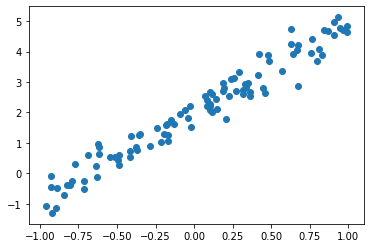

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = torch.rand(100, device=device) * 2 - 1
y = 3 * x + 2 + torch.randn(100, device=device) * 0.4
plt.scatter(x.cpu(), y.cpu());

Now, we will define a linear regressor model and initialize the coeficient a and b to -1 and 1, respectively.

In [40]:
def model(x): return x * a + b

a = torch.randn(1, requires_grad=True, device=device)
b = torch.zeros(1, requires_grad=True, device=device)

We have not trained the model yet, so it is predicting poorly.

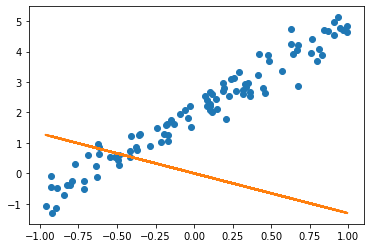

In [41]:
plt.scatter(x.cpu(), y.cpu())
plt.plot(x.cpu().numpy(), model(x).data.cpu().numpy(), c='C1', linewidth=2);

To train the model we will need a loss function. We will use the Mean Squared Error (MSE).

In [42]:
def mse(input, target): 
    return (input - target).pow(2).mean()

We are ready to train now. During the training, on every epoch we will perform 4 steps:
1. Predict, using our model.
2. Compute the loss, using the loss function.
3. Compute the gradients, calling the `backward()` method.
4. Update the weights (a & b) using its gradients. Two comments on this step:
 - After using the gradients, and before calling `backward` again, it is important to reset the gradients (`<variable>.grad.zero_()`)
 - Note that the weights (a & b) are updated inside a `torch.no_grad()` block. This prevents that PyTorch tracks the gradients of these manual updates.

In [43]:
lr = 1e-1
epochs = 100

for i in range(epochs):
    y_hat = model(x)            # predict
    loss = mse(y_hat, y)        # compute loss
    loss.backward()             # backprop
    with torch.no_grad():
        a -= a.grad * lr        # adjust a
        b -= b.grad * lr        # adjust b
    a.grad.zero_()          
    b.grad.zero_()          

Now, we can verify that our model is propertly trained.

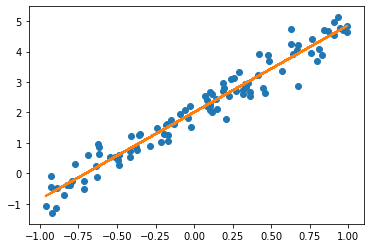

In [46]:
plt.scatter(x.cpu(), y.cpu())
plt.plot(x.cpu().numpy(), model(x).data.cpu().numpy(), c='C1', linewidth=2);

## A Deep Learning framework

PyTorch is also a very powerful and flexible Deep Learning Framework, that allow to create and train Neural Networks easily.

So, let's create a simple Neural Net for the MNIST dataset (handwritten digits) using Pytorch's full functionalities.

### Loading data

In [47]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.notebook import tqdm

In [51]:
MNIST_PATH = Path('~/datasets/mnist_png').expanduser()

The `Transform` class allows to adapt the data to fit into our model. For this dataset, we need to transform images to grayscale (single channel), turn imagenes into tensors and normalize values according dataset's mean and standard deviation.

In [52]:
tfms = transforms.Compose([
           transforms.Grayscale(),
           transforms.ToTensor(),
           transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

Transformations are used to perform data augmentation as well.

Datasets help us loading data to then feed our model. PyTorch provides different kinds of datasets for specific types of data, or you can even create your custom dataset when required.

In [54]:
!ls {MNIST_PATH/'training'}

0  1  2  3  4  5  6  7	8  9


Since in this dataset images are organized by labels in folder, we can use Pytorch's `ImageFolder` dataset class to load our data easily.

In [156]:
train_ds = torchvision.datasets.ImageFolder(MNIST_PATH/'training', tfms)
valid_ds = torchvision.datasets.ImageFolder(MNIST_PATH/'testing', tfms)
len(train_ds), len(valid_ds)

(60000, 10000)

We can retrieve some random sample for the dataset.

In [167]:
idx = torch.randperm(len(train_ds))[0] # random sample
x, y = train_ds[idx]
x.shape, y

(torch.Size([1, 28, 28]), 2)

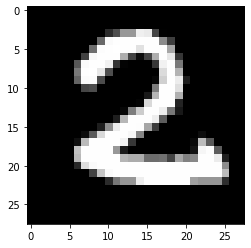

In [168]:
plt.imshow(x.squeeze(), cmap='binary_r');

### Batching data

A dataloader turns a dataset into a generator that yield data in batches. It is ideal to perform Stochastic Gradient Descent (or any its variant), specially when training on GPU where only limited amount of data can fit into memory.

In [169]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=256, shuffle=False, num_workers=4)

We can easily grab and visualize one batch.

In [170]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

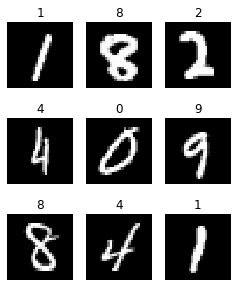

In [171]:
fig, axes = plt.subplots(3, 3, figsize=(4, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(xb[i].squeeze(), cmap='binary_r');
    ax.set_title(yb[i].item())
    ax.axis('off')

### Model

`torch.nn` and `torch.nn.functional` provide handy classes and functions to create custom Neural Nets.

In [172]:
import torch.nn as nn
import torch.nn.functional as F

In [173]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.lin = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.flatten(1)
        return self.lin(x)

In [174]:
model = Model()

To check that our model is working, we can pass a batch to our model.

In [175]:
# sanity check
pred = model(xb)
pred.shape

torch.Size([256, 10])

### Train

`torch.optim` module provides optimization algorithms, such as SGD, Adam, etc.

In [94]:
import torch.optim as optim

Define the hyper-parameters for our model, the loss function, optimizer and metric that we want to use.

In [96]:
def accuracy(input, target):
    preds = input.argmax(dim=1)
    return (preds==target).float().mean().item()

In [178]:
lr = 3e-3
epochs = 5
opt = optim.Adam(model.parameters(), lr)
loss_func = nn.CrossEntropyLoss()
metric = accuracy

And finally, our training loop.

In [179]:
def print_epoch_stats(epoch, train_loss, valid_loss, valid_metric):
    if epoch==0: 
        print(f"epoch  train_loss  valid_loss  valid_metric")
    print(f"{epoch+1:<7}{train_loss:<12.6f}{valid_loss:<12.6f}{valid_metric:<12.6f}")

In [180]:
def fit(model, opt, loss_fn, epochs, train_dl, valid_dl, metric=None):
    model.to(device)
    lr_sched = optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs, 
                                                    eta_min=opt.defaults['lr']/1e6)
    # *** TRAINING LOOP ***
    for epoch in tqdm(range(epochs)):
        train_loss, valid_loss, valid_metric = 0., 0., 0.
        
        # *** TRAIN ***
        model.train()
        for xb, yb in train_dl:                    # iterate every batch
            xb, yb = xb.to(device), yb.to(device)  # move data to GPU
            output = model(xb)                     # predict
            loss = loss_fn(output, yb)             # compute loss
            loss.backward()                        # backprop
            opt.step()                             # adjust weights
            opt.zero_grad()
            lr_sched.step()                              
            train_loss += loss.item() / len(train_dl)
            
        # *** VALIDATION ***
        model.eval()
        for xb, yb in valid_dl:
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad(): output = model(xb)
            loss = loss_fn(output, yb)
            valid_loss += loss.item() / len(valid_dl)
            if metric: 
                valid_metric += metric(output, yb) / len(valid_dl)
        
        print_epoch_stats(epoch, train_loss, valid_loss, valid_metric)

Let's train!

In [181]:
fit(model, opt, loss_func, epochs, train_dl, valid_dl, metric)

epoch  train_loss  valid_loss  valid_metric
1      0.399460    0.207165    0.936816    
2      0.122039    0.097521    0.969043    
3      0.079835    0.078771    0.977344    
4      0.056337    0.064035    0.978613    
5      0.044840    0.062596    0.979004    



### Predict

Fetch one random sample from validatoin set.

In [111]:
idx = torch.randperm(len(valid_ds))[0] # random sample
x,_ = valid_ds[idx]
xb = x[None]

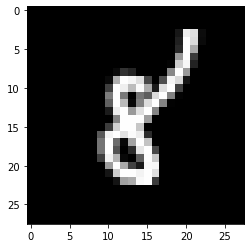

In [112]:
plt.imshow(x.squeeze(), cmap='binary_r');

Let's use our trained model to make a prediction.

In [113]:
xb = xb.to(device)
pred = model(xb)
pred.argmax(1).item()

8

## Custom model example

![fdfd](https://miro.medium.com/max/960/1*Y2rKJdSfOPyED70KUDm6GA.jpeg)

[DeViSE: A Deep Visual-Semantic Embedding Model](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf)

The example is inspired in [this](https://github.com/fastai/fastai/blob/master/courses/dl2/devise.ipynb) notebook from the [Fast.ai](https://course.fast.ai/) course.

In [114]:
from pathlib import Path
import pandas as pd
import fasttext
import PIL.Image as Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

### Data

In [119]:
path = Path('devise/data')
images_path = path/'images'

In [120]:
df = pd.read_csv(path/'items_processed.csv')
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [121]:
train_df.head(3)

,title,image_fn
907348,morral alforja de viaje montagne new ii,788562-MLA25935833228_082017-V.jpg
1628512,remera league of legends diana 4 champion funn...,897575-MLA26284888156_112017-V.jpg
25187,verano colorido de papel 3d grua impresion sue...,680512-MLA30987938798_062019-V.jpg


morral alforja de viaje montagne new ii


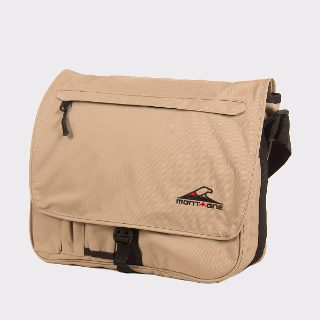

In [122]:
item = train_df.iloc[0]
print(item.title)
Image.open(images_path/item.image_fn)

#### Word2vec

In [ ]:
train_df.title.to_csv(path/'train_titles.txt', index=False, header=False)

fasttext_model = fasttext.train_unsupervised(str(path/'train_titles.txt'), 
                                             model='skipgram', dim=300)

In [ ]:
#fasttext_model.save_model(str(path/'tmp/titles_skipgram.bin'))

In [126]:
fasttext_model = fasttext.load_model(str(path/'tmp/titles_skipgram.bin'))

In [127]:
def cos_sim(word1, word2):
    emb1 = torch.tensor(fasttext_model.get_sentence_vector(word1))[None]
    emb2 = torch.tensor(fasttext_model.get_sentence_vector(word2))[None]
    return F.cosine_similarity(emb1, emb2).item()

In [128]:
cos_sim('remera', 'corbata')

0.2575380206108093

In [14]:
cos_sim('remera', 'musculosa')

0.6373263001441956

In [15]:
cos_sim('zapatillas adidas', 'zapatillas nike')

0.8031125068664551

### Transforms

In [132]:
imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9,1.1)),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)
])

valid_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)
])

### Loading data 

In [135]:
from torch.utils.data import Dataset

In [136]:
class DeviseDataset(Dataset):
    def __init__(self, images_fns, titles, fasttext_model, tfms, images_path):
        self.images_fns = list(images_fns)
        self.titles = list(titles)
        self.fasttext_model = fasttext_model
        self.tfms = tfms
        self.images_path = Path(images_path)
        
    def __getitem__(self, idx):
        img = Image.open(self.images_path/self.images_fns[idx])
        x = self.tfms(img)
        y = self.fasttext_model.get_sentence_vector(self.titles[idx])
        return (x, y)
        
    def __len__(self):
        return len(self.images_fns)

In [137]:
train_ds = DeviseDataset(train_df.image_fn, train_df.title, fasttext_model, 
                         train_tfms, images_path)

valid_ds = DeviseDataset(valid_df.image_fn, valid_df.title, fasttext_model, 
                         valid_tfms, images_path)

In [138]:
# sanity check
len(train_ds), len(valid_ds)

(2504993, 626249)

In [139]:
# sanity check
x, y = valid_ds[0]
x.shape, y.shape

(torch.Size([3, 224, 224]), (300,))

### Batching data

In [140]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4)

In [141]:
# sanity check
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 300]))

### Model

In [146]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        resnet50 = torchvision.models.resnet50(pretrained=True)
        self.conv = nn.Sequential(*list(resnet50.children())[:-2])
        self.lin1 = nn.Linear(4096, 1024)
        self.lin2 = nn.Linear(1024, 300)
        self.bn1 = nn.BatchNorm1d(4096)
        self.bn2 = nn.BatchNorm1d(1024)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        avg_pool = F.adaptive_avg_pool2d(x, 1)
        max_pool = F.adaptive_max_pool2d(x, 1)
        x = torch.cat([avg_pool, max_pool], dim=1)
        x = x.flatten(start_dim=1)
        x = F.relu(self.lin1(self.drop(self.bn1(x))))
        x = self.lin2(self.drop(self.bn2(x)))
        return x

In [147]:
model = Model()

In [148]:
# sanity check
model.to(device)
xb = xb.to(device)
pred = model(xb)
pred.shape

torch.Size([32, 300])

In [149]:
def cos_loss(input, target): 
    return 1 - F.cosine_similarity(input, target).mean()

### Train

In [151]:
lr = 1e-3
epochs = 5
loss_func = cos_loss
opt = optim.Adam(model.parameters(), lr)

In [37]:
# freeze conv
for p in model.conv.parameters(): 
    p.requires_grad = False

In [141]:
fit(model, opt, loss_func, epochs, train_dl, valid_dl)

epoch  train_loss  valid_loss  valid_metric
1      0.229163    0.225243    0.000000    
2      0.227495    0.223422    0.000000    
3      0.224123    0.220513    0.000000    
4      0.223358    0.222471    0.000000    
5      0.222886    0.221314    0.000000    


In [38]:
# unfreeze conv
for p in model.conv.parameters(): 
    p.requires_grad = True

In [40]:
opt = Adam(model.parameters(), lr/100)

In [145]:
fit(model, opt, loss_func, epochs, train_dl, valid_dl)

epoch  train_loss  valid_loss  valid_metric
1      0.220813    0.217605    0.000000    
2      0.216054    0.212709    0.000000    
3      0.212545    0.209127    0.000000    
4      0.210191    0.209710    0.000000    
5      0.209219    0.209417    0.000000    


In [108]:
#torch.save(model.cpu().state_dict(), path/'model_stage2.pt')

In [123]:
#model.load_state_dict(torch.load(path/'model_stage2.pt'));

### Predict

In [96]:
def predict(img):
    model.to(device)
    model.eval()
    x = valid_tfms(img)[None]
    with torch.no_grad():
        return model(x.to(device)).cpu()

In [ ]:
model.eval()
with torch.no_grad():
    preds = torch.cat([model(xb.to(device)).cpu() for xb, _ in valid_dl])

In [64]:
#preds = torch.load(path/'valid_preds.pt')

#### KNN indexation

In [65]:
import nmslib

In [66]:
def create_index(a):
    index = nmslib.init(space='cosinesimil')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knn(index, vec, k=5): 
    return index.knnQuery(vec, k)

In [67]:
index = create_index(preds)

#### Visualization functions

In [68]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols=5, figsize=(12,6)):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): 
        show_img(ims[i], ax=ax)
    plt.tight_layout()

#### Text -> Image

In [97]:
def text2image(text):
    vec = fasttext_model.get_sentence_vector(text)
    idxs, dists = get_knn(index, vec)
    imgs = [Image.open(images_path/valid_df.image_fn.iloc[i]) for i in idxs]
    show_imgs(imgs)

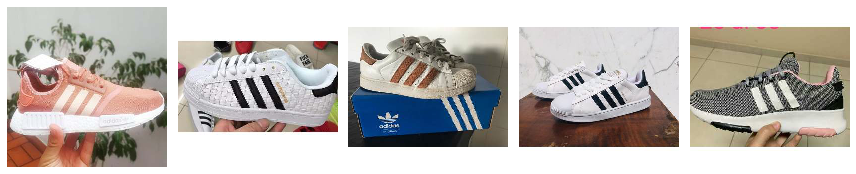

In [98]:
text2image("zapatillas adidas")

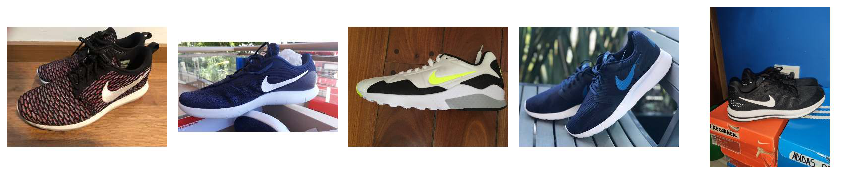

In [99]:
text2image("zapatillas nike")

#### Image -> Image

In [124]:
def image2image(img):
    vec = predict(img)
    idxs, _ = get_knn(index, vec, 6)
    imgs = [Image.open(images_path/valid_df.image_fn.iloc[i]) for i in idxs[1:]]
    show_imgs(imgs)

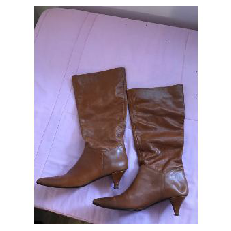

In [125]:
i = 42
img = Image.open(images_path/valid_df.image_fn.iloc[i])
show_img(img);

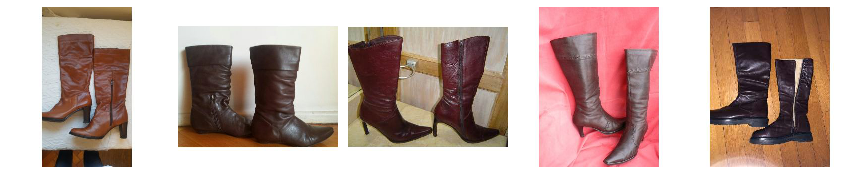

In [126]:
image2image(img)

#### Image + Text -> Image

In [127]:
def image_and_text2image(img, text):
    img_vec = predict(img)
    txt_vec = torch.tensor(fasttext_model.get_word_vector(text))
    vec = img_vec + txt_vec * 100
    idxs, _ = get_knn(index, vec, 1)
    img = Image.open(images_path/valid_df.image_fn.iloc[idxs[0]])
    show_img(img)

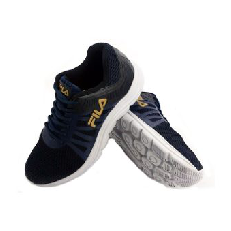

In [128]:
i = 2
img = Image.open(images_path/valid_df.image_fn.iloc[i])
show_img(img);

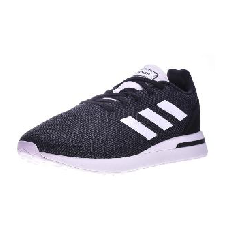

In [129]:
image_and_text2image(img, "adidas")

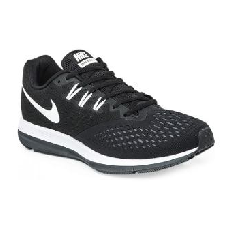

In [130]:
image_and_text2image(img, "nike")

## End